In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.1 MB/s eta 0:00:00


In [3]:
import os

# Path where training data is stored
train_data_path = "/content/drive/MyDrive/Dataset/splitset/"

# Get participant IDs from existing training files
train_participants = [
    file.split("_")[0] for file in os.listdir(train_data_path) if file.endswith("_train.mat")
]
train_participants = sorted(set(map(int, train_participants)))  # Ensure unique and sorted IDs

print("Loaded train participants:", train_participants)

Loaded train participants: [1, 2, 3, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 29, 30, 31, 32, 33, 35, 36, 37, 39, 42, 43, 45, 46, 47, 48]


In [4]:
import numpy as np
import scipy.io
import pywt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import joblib

# Parameters
sampling_rate = 256
selected_channels = [3, 5, 8, 14, 17, 19, 24, 25, 36, 39, 40, 45, 47, 52, 53]
selected_channels = [ch - 1 for ch in selected_channels]  # Convert to 0-based indexing

# Adjusted frequency bands (respecting 0.5-20Hz filter)
alpha_band = (8, 13)    # alpha band limited by upper cutoff
full_band = (0.5, 20)   # Effective frequency range

# Function to compute power using CWT
def compute_power_cwt(signal, scales, wavelet):
    coefficients, _ = pywt.cwt(signal, scales, wavelet, sampling_period=1.0/sampling_rate)
    return np.abs(coefficients) ** 2  # Power

# Initialize list to store relative alpha power features
all_relative_alpha_power = []

# Wavelet parameters - using narrower bandwidth for better frequency resolution
wavelet = 'cmor1.0-1.5'  # Complex Morlet wavelet optimized for limited bandwidth

# Loop through each participant
for participant in train_participants:
    # Load the .mat file
    train_file_path = f'/content/drive/MyDrive/Dataset/splitset/{int(participant)}_train.mat'
    data = scipy.io.loadmat(train_file_path)
    participant_data = data['train_data']  # Shape: (timepoints, channels, trials)

    # Segment parameters
    trial_duration = 1.5  # seconds
    segment_duration = 20  # seconds
    trials_per_segment = int(segment_duration / trial_duration)

    # Window parameters
    window_duration = 5  # seconds
    window_length = window_duration * sampling_rate
    overlap = 0.5  # 50% overlap
    step_size = int(window_length * (1 - overlap))

    for start in range(0, participant_data.shape[2] - trials_per_segment + 1, trials_per_segment):
        # Extract segment
        segment = participant_data[:, selected_channels, start:start+trials_per_segment]
        segment = segment.reshape(-1, len(selected_channels))[:20*sampling_rate, :]

        # Process each window
        for i in range(0, len(segment) - window_length + 1, step_size):
            window = segment[i:i+window_length, :]
            window_features = []

            for ch in range(len(selected_channels)):
                # Compute total power (within effective band)
                scales_full = pywt.frequency2scale(wavelet, np.array(full_band)/sampling_rate)
                total_power = compute_power_cwt(window[:, ch], scales_full, wavelet).sum()

                # Compute alpha power (limited to 13-20Hz)
                scales_alpha = pywt.frequency2scale(wavelet, np.array(alpha_band)/sampling_rate)
                alpha_power = compute_power_cwt(window[:, ch], scales_alpha, wavelet).sum()

                # Calculate relative alpha power (with protection against division by zero)
                relative_alpha = alpha_power / total_power if total_power > 0 else 0
                window_features.append(relative_alpha)

            # Average across channels
            all_relative_alpha_power.append(np.mean(window_features))

# Convert to numpy array and reshape for clustering
X = np.array(all_relative_alpha_power).reshape(-1, 1)



In [7]:
# Normalize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Save the scaler
scaler_path = "/content/drive/MyDrive/Dataset/clustering_models/Kmeans_RAP_Scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")



Scaler saved to /content/drive/MyDrive/Dataset/clustering_models/Kmeans_RAP_Scaler.pkl


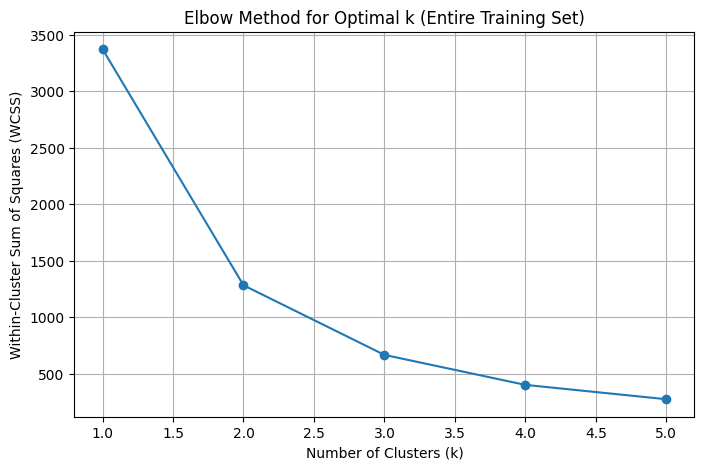

In [8]:
#Determine the optimal number of clusters using the elbow method
wcss = []
K_range = range(1, 6)  # Test 1 to 5 clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_normalized)
    wcss.append(kmeans.inertia_)  # Inertia (within-cluster sum of squares)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k (Entire Training Set)')
plt.grid()
plt.show()

For n_clusters = 2, the average silhouette score is 0.565
For n_clusters = 3, the average silhouette score is 0.535
For n_clusters = 4, the average silhouette score is 0.534
For n_clusters = 5, the average silhouette score is 0.529
For n_clusters = 6, the average silhouette score is 0.523


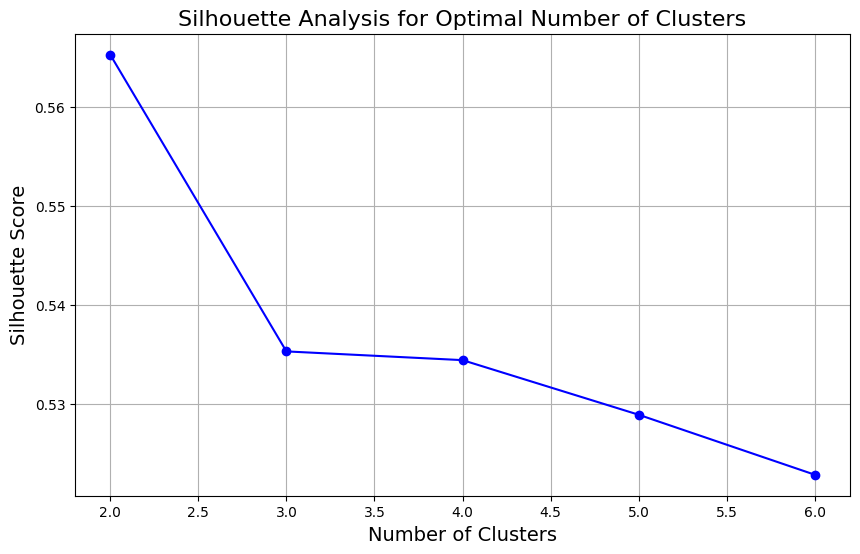

In [9]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

# Apply the silhouette method
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_scores = []

# Loop through different numbers of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X_normalized)
    silhouette_avg = silhouette_score(X_normalized, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg:.3f}")

# Plot silhouette scores for each number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='-', color='blue')
plt.title("Silhouette Analysis for Optimal Number of Clusters", fontsize=16)
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.grid()
plt.show()

For n_clusters = 2, the Davies-Bouldin Index is 0.617
For n_clusters = 3, the Davies-Bouldin Index is 0.568
For n_clusters = 4, the Davies-Bouldin Index is 0.544
For n_clusters = 5, the Davies-Bouldin Index is 0.536
For n_clusters = 6, the Davies-Bouldin Index is 0.533


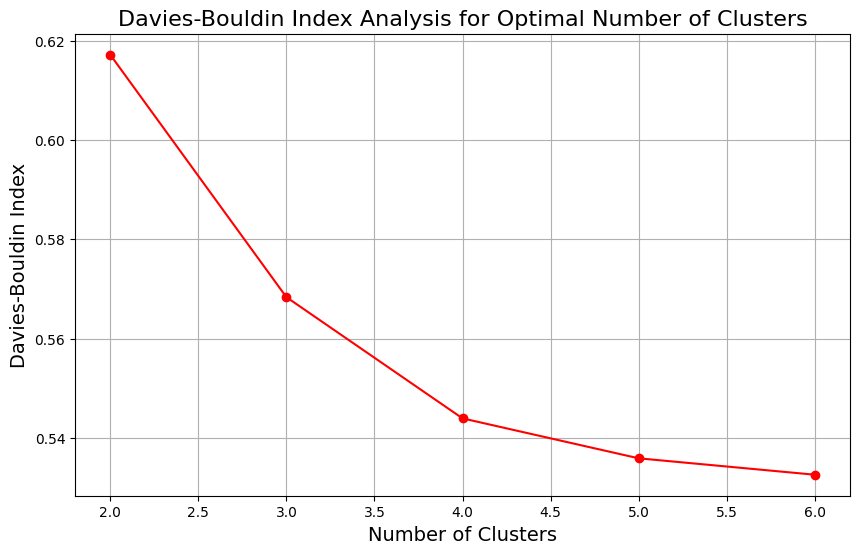

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

range_n_clusters = [2, 3, 4, 5, 6]
dbi_scores = []

# Loop through different numbers of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X_normalized)
    dbi_score = davies_bouldin_score(X_normalized, cluster_labels)
    dbi_scores.append(dbi_score)
    print(f"For n_clusters = {n_clusters}, the Davies-Bouldin Index is {dbi_score:.3f}")

# Plot DBI scores for each number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, dbi_scores, marker='o', linestyle='-', color='red')
plt.title("Davies-Bouldin Index Analysis for Optimal Number of Clusters", fontsize=16)
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("Davies-Bouldin Index", fontsize=14)
plt.grid()
plt.show()



Model saved to /content/drive/MyDrive/Dataset/clustering_models/Kmeans_RAP_Model.pkl
Centroids: [[ 0.20975439]
 [-0.90533787]
 [ 1.7396399 ]]


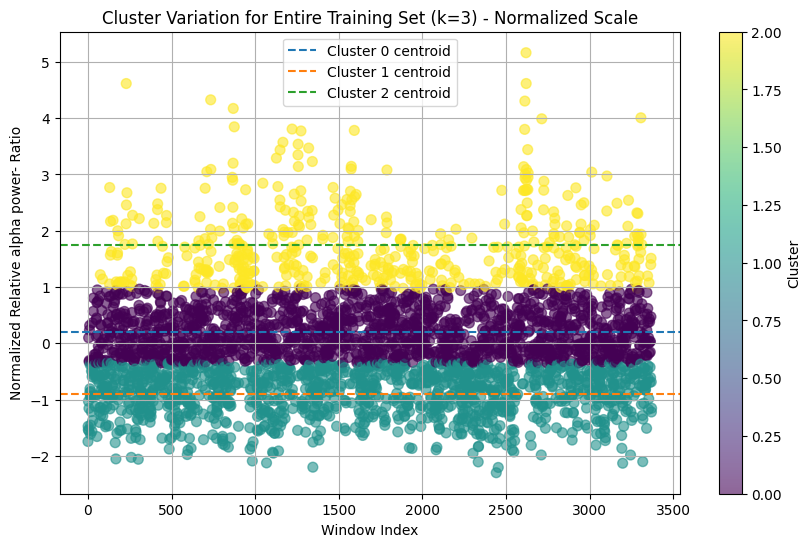

In [11]:
# Perform K-Means clustering on normalized features
optimal_k = 3  # Set based on the elbow method

kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_normalized)

# Save the model for later use
model_path = "/content/drive/MyDrive/Dataset/clustering_models/Kmeans_RAP_Model.pkl"
joblib.dump(kmeans, model_path)
print(f"Model saved to {model_path}")

centroids = kmeans.cluster_centers_
print(f"Centroids: {centroids}")

# Plotting with Normalized Features
plt.figure(figsize=(10, 6))
plt.scatter(range(len(X_normalized)), X_normalized, c=clusters, cmap='viridis', s=50, alpha=0.6)

# Plot centroids
for i, centroid in enumerate(centroids):
    plt.axhline(y=centroid, color=f'C{i}', linestyle='--', label=f'Cluster {i} centroid')

plt.xlabel('Window Index')
plt.ylabel('Normalized Relative alpha power- Ratio')
plt.title(f'Cluster Variation for Entire Training Set (k={optimal_k}) - Normalized Scale')
plt.colorbar(label='Cluster')
plt.legend()
plt.grid()
plt.show()